In [1]:
from glob import glob
from natsort import natsorted
from pathlib import Path
import json
import scipy.io as scio
from typing import Dict
from asclepius.data import prepare_patient_data, loadmat_custom, calculate_split_bounds
import numpy as np
import matplotlib.pyplot as plt
from skimage.exposure import rescale_intensity

In [2]:
dataset_root = Path("/home/varun/xia_lab/repos/paus_2dcs/dataset")

In [3]:
metadata_path = dataset_root.joinpath("metadata.json")

In [4]:
with open(metadata_path, "r") as jf:
    metadata = json.load(jf)

In [5]:
metadata

{'RP065': {'metadata': {'malignant': 'left',
   'clock': None,
   'size': [70, 59, None]},
  'pa': {'flip': [1],
   'half': 'lower',
   'trim': {'0': [0, None], '1': [0, None], '2': [50, -50]}},
  'us': {'flip': None,
   'half': 'lower',
   'trim': {'0': [0, -100], '1': [0, None], '2': [50, -50]}},
  'tumor_bounds': {'depth': [80, 100], 'sides': [250, 375]}},
 'RP067': {'metadata': {'malignant': 'left',
   'clock': None,
   'size': [None, None, None]},
  'pa': {'flip': None,
   'half': 'lower',
   'trim': {'0': [0, None], '1': [0, -5], '2': [0, None]}},
  'us': {'flip': None,
   'half': 'lower',
   'trim': {'0': [0, None], '1': [0, -5], '2': [0, None]}},
  'tumor_bounds': {'depth': [0, None], 'sides': [400, 485]}},
 'RP068': {'metadata': {'malignant': 'right',
   'clock': 11,
   'size': [None, None, None]},
  'pa': {'flip': None,
   'half': 'lower',
   'trim': {'0': [0, None], '1': [0, -5], '2': [0, None]}},
  'us': {'flip': None,
   'half': 'lower',
   'trim': {'0': [0, None], '1': [0

In [6]:
def load_preprocess(patient_dir: Path, patient_metadata: Dict):
    pa_arr = loadmat_custom(glob(f"{patient_dir}/pa*.mat")[0])
    us_arr = loadmat_custom(glob(f"{patient_dir}/us*.mat")[0])

    preprocessed = prepare_patient_data({"pa_mat": pa_arr, "us_mat": us_arr}, patient_metadata)
    
    pa_arr = preprocessed["pa_arr"]
    us_arr = preprocessed["us_arr"]

    return pa_arr, us_arr

In [18]:
def norm_amp(pa_arr, us_arr, patient_metadata, norm="vol"):
    pa_arr_shape = pa_arr.shape
    us_arr_shape = us_arr.shape
    
    buffer = 10
    
    tumor_bounds = patient_metadata["tumor_bounds"]["sides"]
    discard_bounds = [
        [tumor_bounds[0] - buffer // 2, tumor_bounds[0] + buffer // 2],
        [tumor_bounds[1] - buffer // 2, tumor_bounds[1] + buffer // 2],
    ]
    tumor_bounds = [tumor_bounds[0] + buffer // 2, tumor_bounds[1] - buffer // 2]
    
    if norm=="vol":
        pa_norm = rescale_intensity(pa_arr, out_range=(0,1))
        us_norm = rescale_intensity(us_arr, out_range=(0,1))
    elif norm=="frame":
        pa_norm = np.zeros(pa_arr.shape)
        for i in range(pa_arr.shape[-1]):
            pa_norm[:,:,i] = rescale_intensity(pa_arr[:,:,i], out_range=(0,1))

        us_norm = np.zeros(us_arr.shape)
        for i in range(us_arr.shape[-1]):
            us_norm[:,:,i] = rescale_intensity(us_arr[:,:,i], out_range=(0,1))
    
    frame_count = pa_norm.shape[-1]
    padded_bounds, tumor_bounds = calculate_split_bounds("bal", frame_count, patient_metadata)
    
    start_index, end_index = padded_bounds
    tumor_start, tumor_end = tumor_bounds

    pa_frame_shape = pa_norm.shape[:-1]
    us_frame_shape = us_norm.shape[:-1]
    
    for cs_index in range(frame_count):
        if (cs_index < start_index) or (cs_index > end_index) or (cs_index > discard_bounds[0][0] and cs_index < discard_bounds[0][1]) or (cs_index > discard_bounds[1][0] and cs_index < discard_bounds[1][1]): # discard - split
            pa_norm[:,:,cs_index] = np.zeros(pa_frame_shape)
            us_norm[:,:,cs_index] = np.zeros(us_frame_shape)
        else:
            if cs_index > tumor_start and cs_index < tumor_end:
                pa_norm[:,:,cs_index] = pa_norm[:,:,cs_index]*2
                us_norm[:,:,cs_index] = us_norm[:,:,cs_index]*2
    return pa_norm, us_norm

In [14]:
patient_dirs = natsorted(glob(f"{dataset_root}/RP*/"))

In [15]:
patient_dirs

['/home/varun/xia_lab/repos/paus_2dcs/dataset/RP065/',
 '/home/varun/xia_lab/repos/paus_2dcs/dataset/RP067/',
 '/home/varun/xia_lab/repos/paus_2dcs/dataset/RP068/',
 '/home/varun/xia_lab/repos/paus_2dcs/dataset/RP070/',
 '/home/varun/xia_lab/repos/paus_2dcs/dataset/RP075/',
 '/home/varun/xia_lab/repos/paus_2dcs/dataset/RP079/',
 '/home/varun/xia_lab/repos/paus_2dcs/dataset/RP088/',
 '/home/varun/xia_lab/repos/paus_2dcs/dataset/RP090/',
 '/home/varun/xia_lab/repos/paus_2dcs/dataset/RP093/',
 '/home/varun/xia_lab/repos/paus_2dcs/dataset/RP094/',
 '/home/varun/xia_lab/repos/paus_2dcs/dataset/RP096/',
 '/home/varun/xia_lab/repos/paus_2dcs/dataset/RP097/',
 '/home/varun/xia_lab/repos/paus_2dcs/dataset/RP101/']

In [16]:
def plot_all(pa_arr, pa_norm, us_arr, us_norm, patient_metadata, patient_name):
    depth_slice = patient_metadata["tumor_bounds"]["depth"]
    
    plt.figure(figsize=(16,8))  # Create a new figure
    plt.suptitle(patient_name)
    
    plt.subplot(2, 2, 1)
    plt.imshow(np.max(pa_arr, axis=0), "hot")
    plt.colorbar()
    plt.title("PA")
    
    plt.subplot(2, 2, 2)
    plt.imshow(np.mean(us_arr[depth_slice[0]:depth_slice[1],:,:], axis=0), "gray")
    plt.colorbar()
    plt.title("US")
    
    plt.subplot(2, 2, 3)
    plt.imshow(np.max(pa_norm, axis=0), "hot", vmin=0, vmax=2)
    plt.colorbar()
    plt.title("PA - tumor")
    
    plt.subplot(2, 2, 4)
    plt.imshow(np.mean(us_norm[depth_slice[0]:depth_slice[1],:,:], axis=0), "gray", vmin=0, vmax=2)
    plt.colorbar()
    plt.title("US - tumor")
    
    plt.tight_layout()
    plt.savefig(f"{patient_name}.png")
    plt.show()  # Display the plot in the current cell

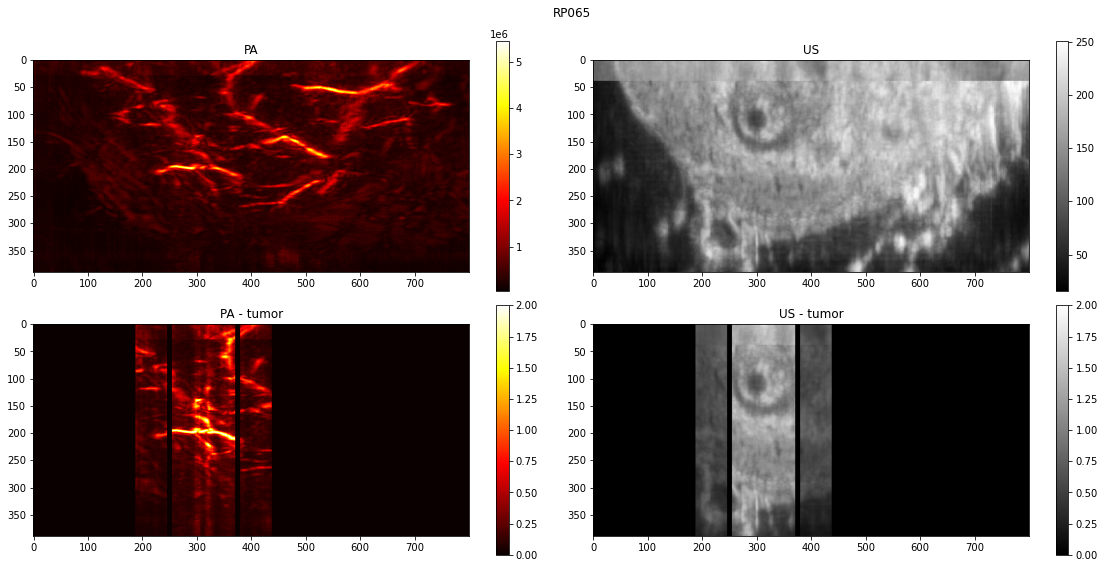

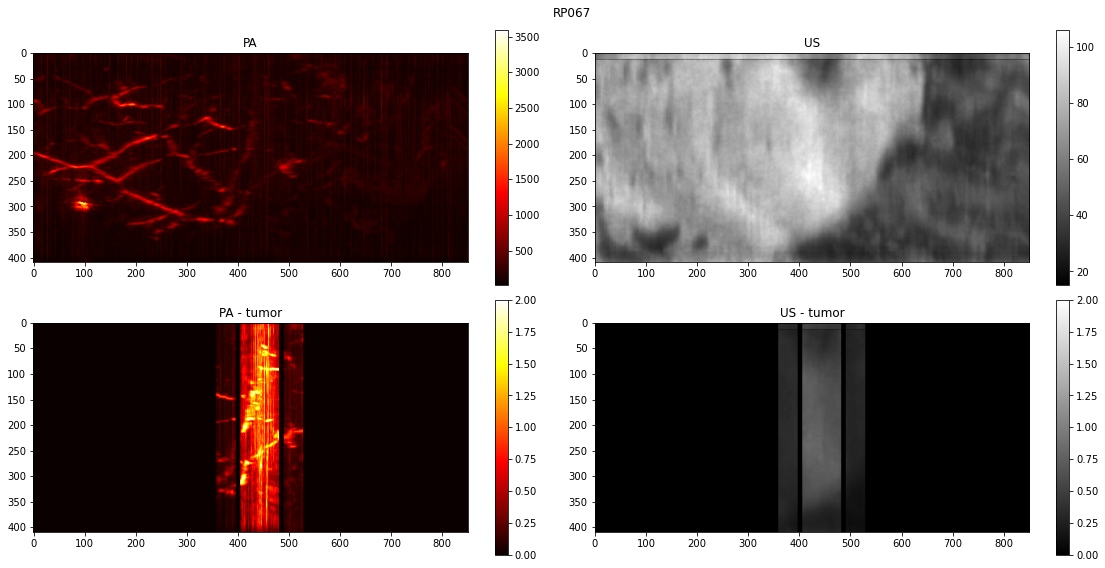

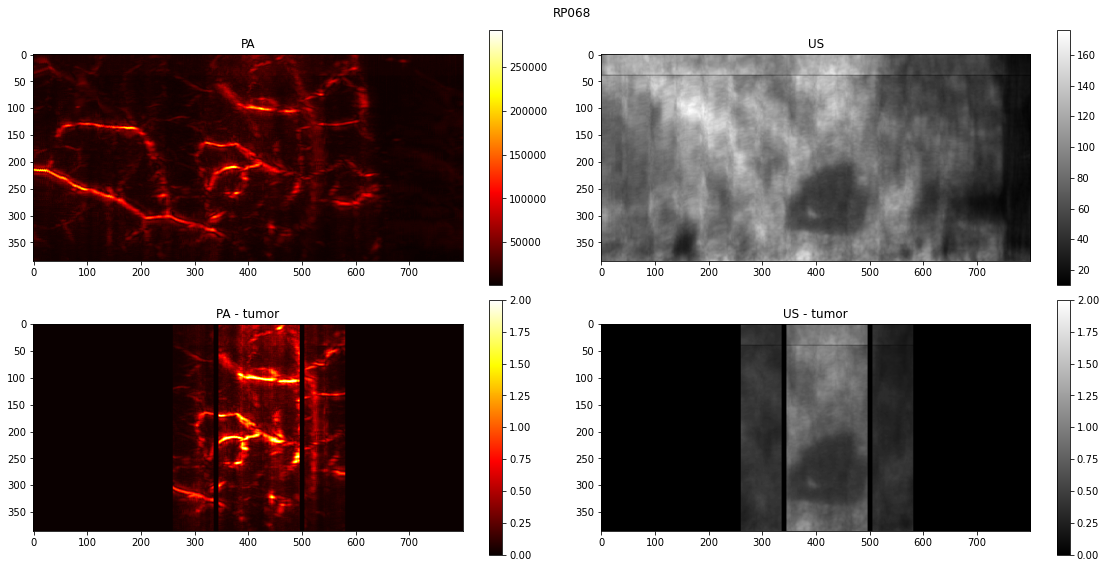

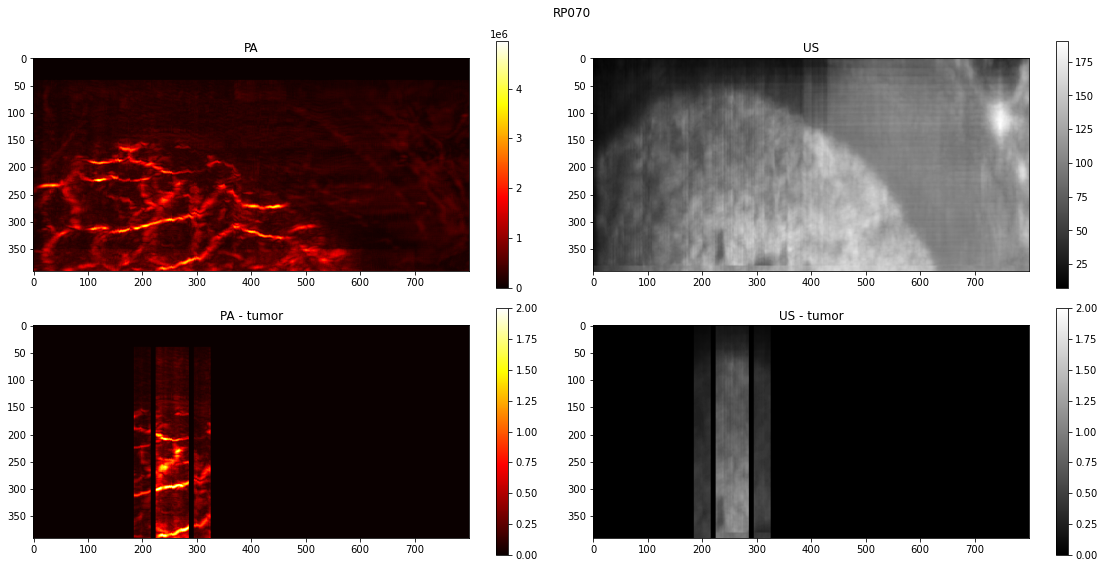

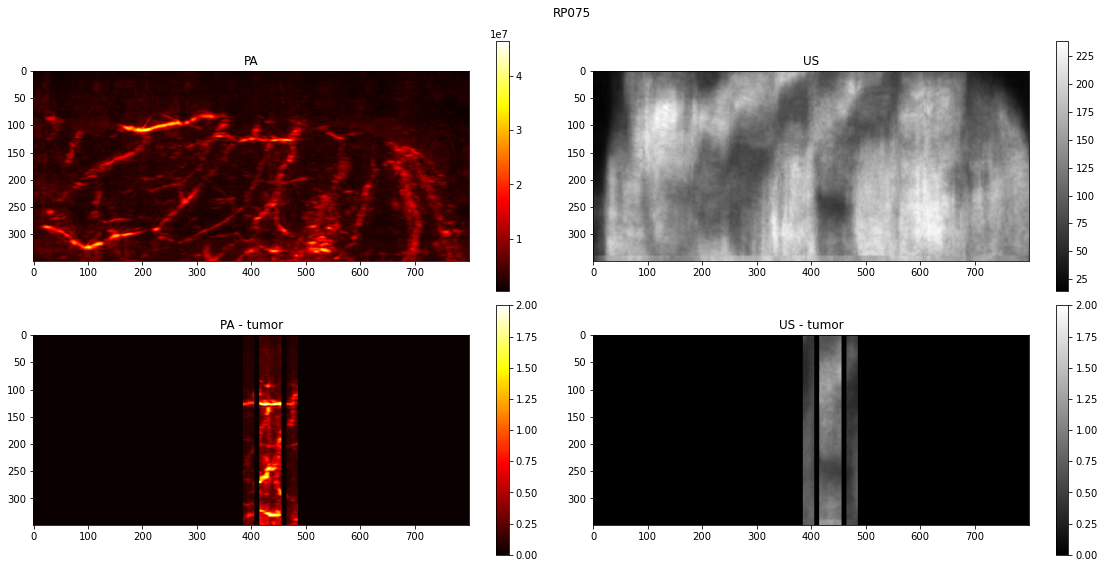

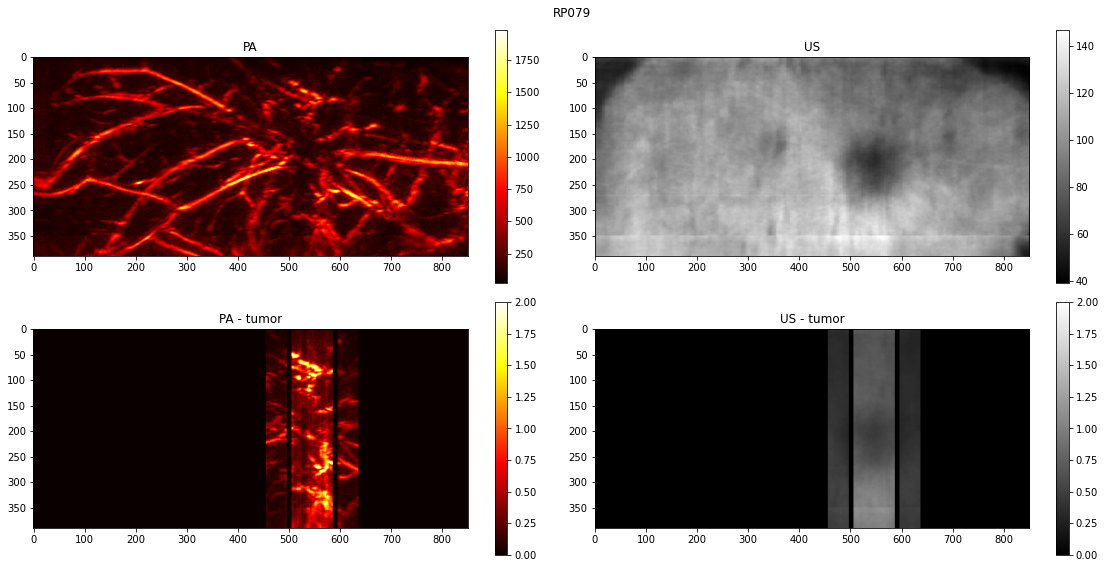

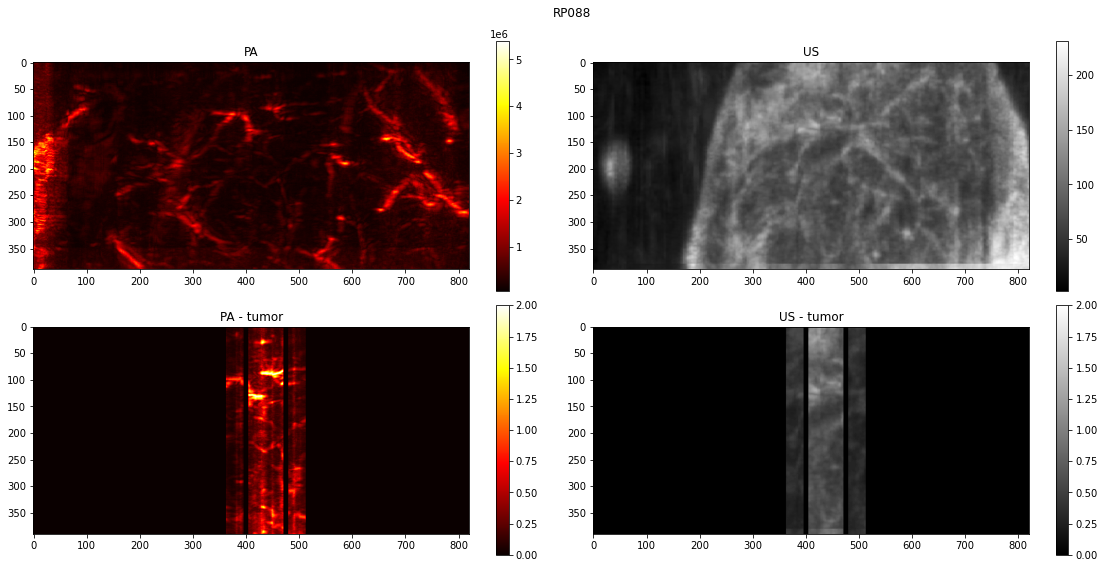

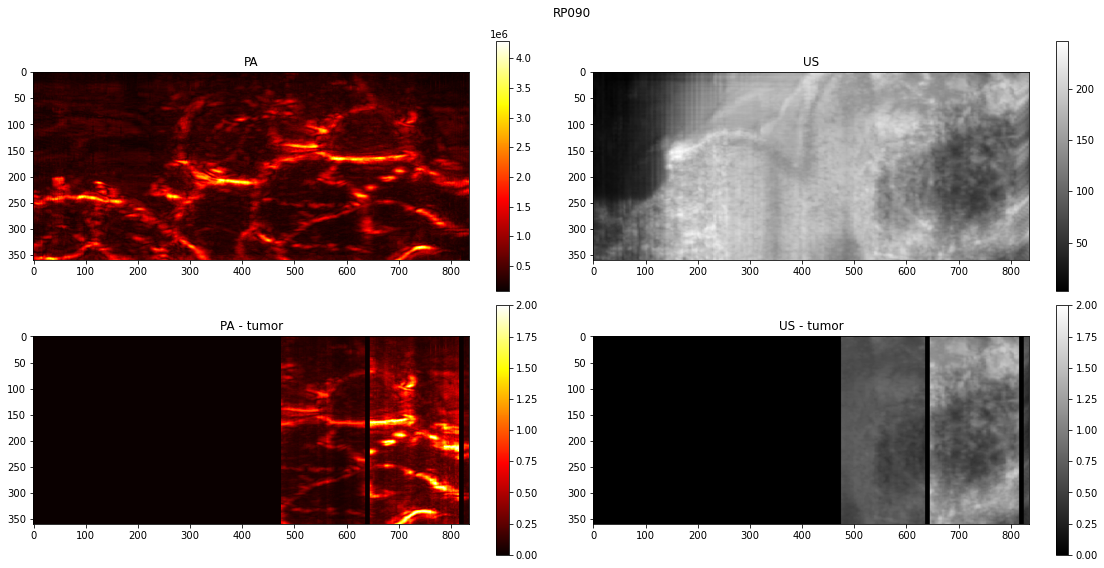

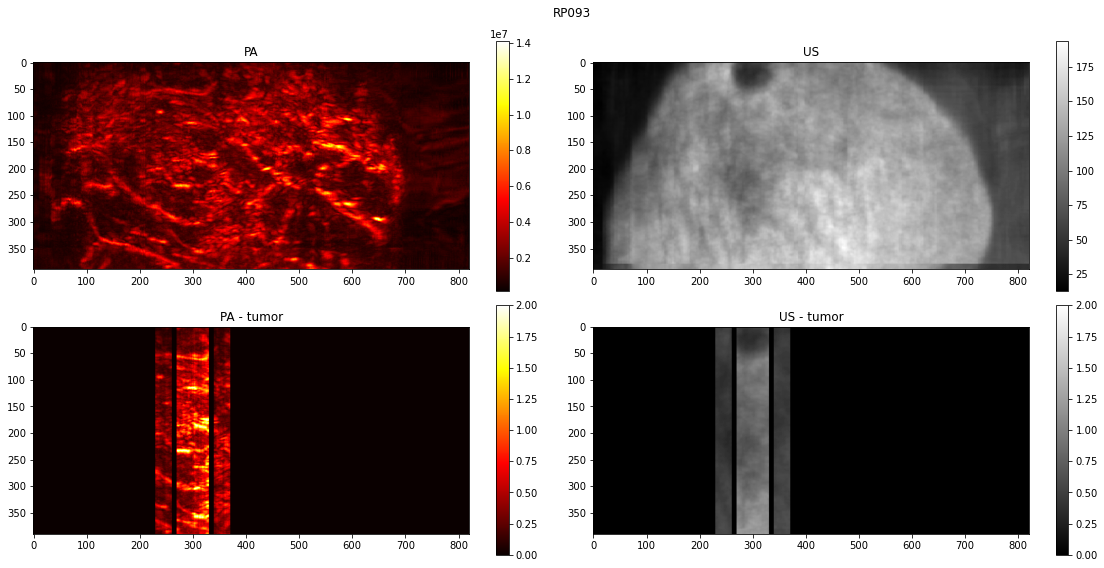

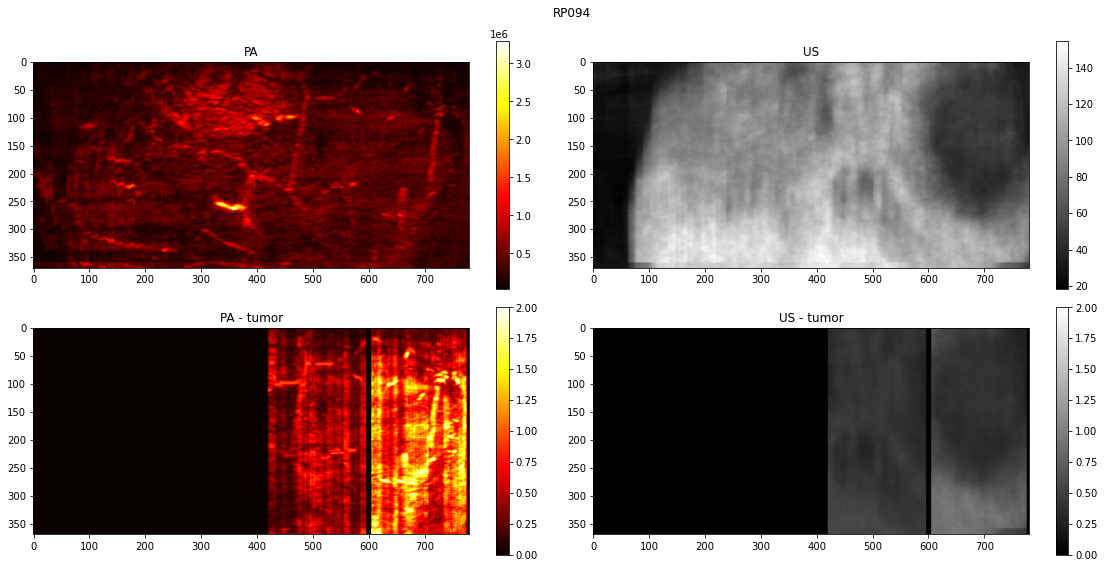

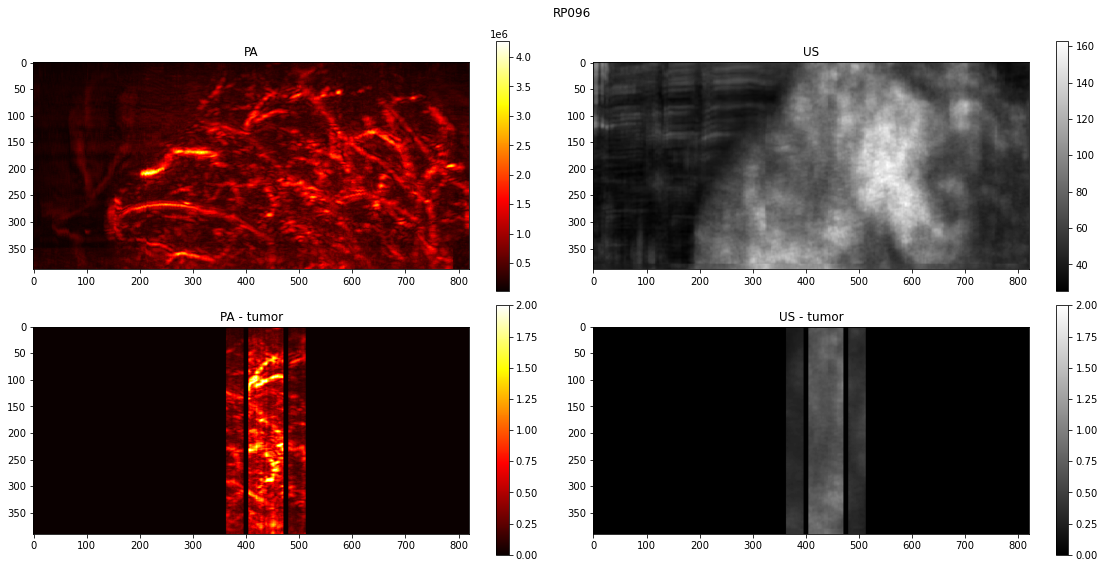

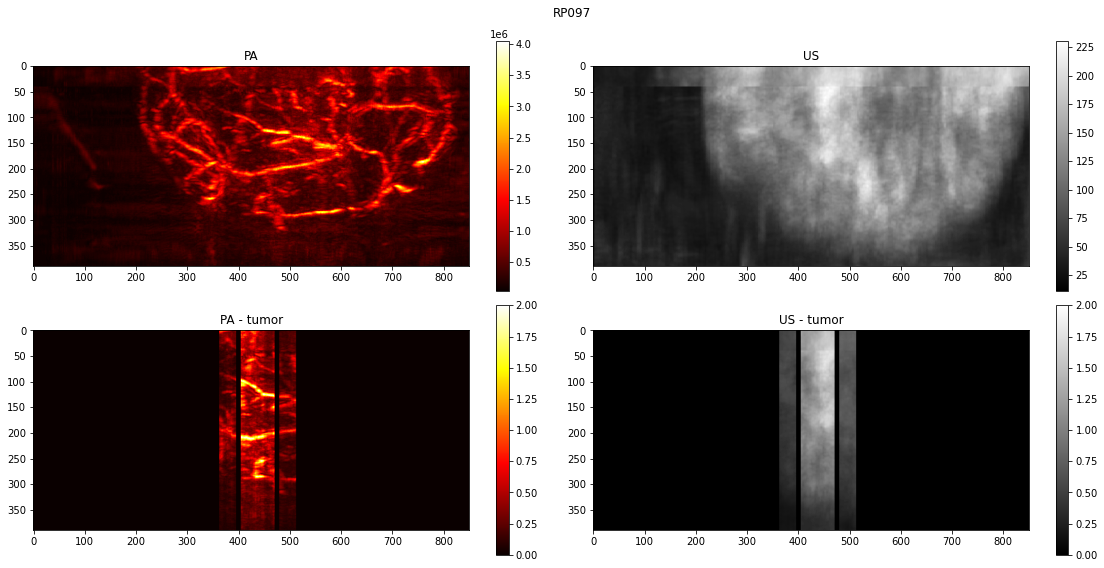

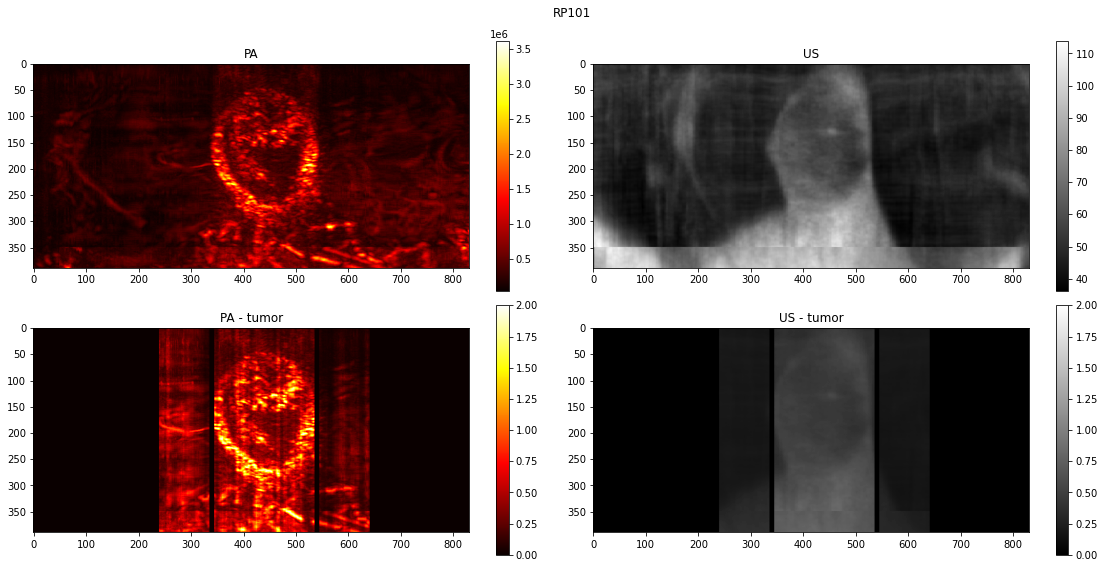

In [19]:
for patient_dir in patient_dirs:
    patient_path = Path(patient_dir)
    patient_name = patient_path.stem
    patient_metadata = metadata[patient_name]
    pa_arr, us_arr = load_preprocess(Path(patient_dir), patient_metadata)
    pa_norm, us_norm = norm_amp(pa_arr, us_arr, patient_metadata, norm="frame")
    plot_all(pa_arr, pa_norm, us_arr, us_norm, patient_metadata, patient_name)